In [9]:
import argparse
import os
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision.datasets import ImageFolder
from PIL import Image
import matplotlib.pyplot as plt

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1000, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=128, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=400, help="interval between image sampling")
opt, unknown = parser.parse_known_args()
print(opt)

cuda = True if torch.cuda.is_available() else False

d_losses = []
g_losses = []

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Configure data loader
#os.makedirs("../../data/mnist", exist_ok=True)
dataset = ImageFolder(
    root='Yorpath',
    transform=transforms.Compose([
        transforms.Resize(opt.img_size),
        transforms.CenterCrop(opt.img_size),  # You may adjust this if needed
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Assuming grayscale images
    ])
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

for epoch in range(opt.n_epochs):
    d_loss_epoch = 0.0
    g_loss_epoch = 0.0
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))

        # Generate a batch of images
        gen_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        # Update epoch losses
        d_loss_epoch += d_loss.item()
        g_loss_epoch += g_loss.item()

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
            % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        )

        batches_done = epoch * len(dataloader) + i
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[:25], "nCT%d.jpg" % batches_done, nrow=5, normalize=True)
            
    # Calculate average losses for the epoch
    d_loss_avg = d_loss_epoch / len(dataloader)
    g_loss_avg = g_loss_epoch / len(dataloader)
    
    # Store average losses
    d_losses.append(d_loss_avg)
    g_losses.append(g_loss_avg)

# Save generator and discriminator models
torch.save(generator.state_dict(), "YourPath")
torch.save(discriminator.state_dict(), "YourPath")

# Save other necessary information
torch.save({
    'optimizer_G_state_dict': optimizer_G.state_dict(),
    'optimizer_D_state_dict': optimizer_D.state_dict(),
    'opt': vars(opt)  # Save training configurations
}, "YourPath")


Namespace(n_epochs=1000, batch_size=64, lr=0.0002, b1=0.5, b2=0.999, n_cpu=8, latent_dim=100, img_size=128, channels=1, sample_interval=400)
[Epoch 0/1000] [Batch 0/69] [D loss: 0.693222] [G loss: 0.694787]
[Epoch 0/1000] [Batch 1/69] [D loss: 0.692999] [G loss: 0.694000]
[Epoch 0/1000] [Batch 2/69] [D loss: 0.692965] [G loss: 0.693323]
[Epoch 0/1000] [Batch 3/69] [D loss: 0.692812] [G loss: 0.693060]
[Epoch 0/1000] [Batch 4/69] [D loss: 0.692543] [G loss: 0.693099]
[Epoch 0/1000] [Batch 5/69] [D loss: 0.692323] [G loss: 0.693328]
[Epoch 0/1000] [Batch 6/69] [D loss: 0.691842] [G loss: 0.693683]
[Epoch 0/1000] [Batch 7/69] [D loss: 0.691170] [G loss: 0.694282]
[Epoch 0/1000] [Batch 8/69] [D loss: 0.690238] [G loss: 0.694749]
[Epoch 0/1000] [Batch 9/69] [D loss: 0.688675] [G loss: 0.695509]
[Epoch 0/1000] [Batch 10/69] [D loss: 0.687146] [G loss: 0.696284]
[Epoch 0/1000] [Batch 11/69] [D loss: 0.681424] [G loss: 0.697171]
[Epoch 0/1000] [Batch 12/69] [D loss: 0.677231] [G loss: 0.697823

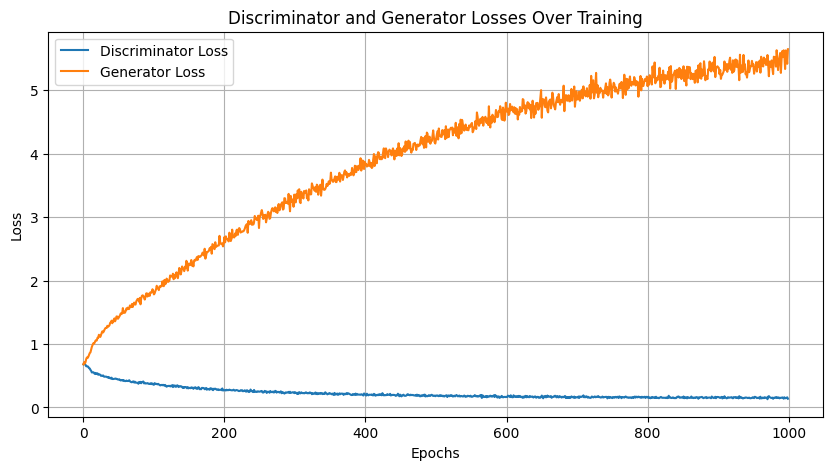

In [11]:
# Plot error diagrams
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Discriminator and Generator Losses Over Training")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Create the directory to save generated images
output_dir = "YourPath"
os.makedirs(output_dir, exist_ok=True)

generator.eval()
n_samples = 100


for i in range(n_samples):
    
    z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size, opt.latent_dim))))
    gen_imgs = generator(z)
    for j in range(opt.batch_size):
        save_image(gen_imgs[j], os.path.join(output_dir, f"image_{i * opt.batch_size + j}.png"), normalize=True)
